In [1]:
import pandas as pd 
import numpy as np 


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, median_absolute_error

from datetime import datetime, timedelta
import time
from collections import namedtuple

import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline


import scipy.stats as st
import sklearn.metrics as sm

import statsmodels.api as sm


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Loading the dataset into a DataFrame
df = pd.read_csv('austin_weather.csv', parse_dates=['Date'], infer_datetime_format=True)
df

,Date,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,...,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
0,2013-12-21,74,60,45,67,49,43,93,75,57,...,29.68,29.59,10,7,2,20,4,31,0.46,"Rain , Thunderstorm"
1,2013-12-22,56,48,39,43,36,28,93,68,43,...,30.13,29.87,10,10,5,16,6,25,0,
2,2013-12-23,58,45,32,31,27,23,76,52,27,...,30.49,30.41,10,10,10,8,3,12,0,
3,2013-12-24,61,46,31,36,28,21,89,56,22,...,30.45,30.3,10,10,7,12,4,20,0,
4,2013-12-25,58,50,41,44,40,36,86,71,56,...,30.33,30.27,10,10,7,10,2,16,T,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1314,2017-07-27,103,89,75,71,67,61,82,54,25,...,29.97,29.88,10,10,10,12,5,21,0,
1315,2017-07-28,105,91,76,71,64,55,87,54,20,...,29.9,29.81,10,10,10,14,5,20,0,
1316,2017-07-29,107,92,77,72,64,55,82,51,19,...,29.86,29.79,10,10,10,12,4,17,0,
1317,2017-07-30,106,93,79,70,68,63,69,48,27,...,29.91,29.87,10,10,10,13,4,20,0,


In [3]:
# Listing existing features from the dataset
features = ["Date", "TempAvgF", "DewPointAvgF", "SeaLevelPressureAvgInches", "HumidityHighPercent", "HumidityLowPercent", "TempHighF",
            "TempLowF", "DewPointHighF", "DewPointLowF", "SeaLevelPressureHighInches", "SeaLevelPressureLowInches", "PrecipitationSumInches"]

# Setting Date column in the DataFrame as index
df.set_index('Date', inplace=True)

# Creating temporary DataFrame with Average temperature and Average Dew temperature of first five records
temp = df[['TempAvgF', 'DewPointAvgF']].head()
temp

,TempAvgF,DewPointAvgF
Date,,
2013-12-21,60,49
2013-12-22,48,36
2013-12-23,45,27
2013-12-24,46,28
2013-12-25,50,40


In [4]:
# A function to add a column (feature)
# with N times shifted values for the row's prior measurement values of the specified feature
# For example, if N = 1, the value in the new column for today's average temperature
#              will be the average temperature of yesterday
def derive_feature_for_nth_day(feature, df, N):
    
    # total number of rows
    rows = df.shape[0]
    
    # Creating a list representing Nth prior measurements of feature
    # The front of the list needs to be padded with N times null to maintain the row length
    nth_prior_measurements = [None]*N + [df[feature][i-N] for i in range(N, rows)]

    # Creating a new column name in the feature_N format
    col_name = "{}_{}".format(feature, N)
    
    # Adding the column to the DataFrame
    df[col_name] = nth_prior_measurements

In [5]:
# Adding new columns to df shifting 1 and 2 rows (N=1 & N=2) values for each column
for feature in features:
    #Avoid altering the Date column in the DataFrame
    if feature != 'Date':
        #Specifying range for N
        for N in range(1, 3):
            derive_feature_for_nth_day(feature, df, N)
            
# Listing all features (including newly added features)
df.columns

Index(['TempHighF', 'TempAvgF', 'TempLowF', 'DewPointHighF', 'DewPointAvgF',
       'DewPointLowF', 'HumidityHighPercent', 'HumidityAvgPercent',
       'HumidityLowPercent', 'SeaLevelPressureHighInches',
       'SeaLevelPressureAvgInches', 'SeaLevelPressureLowInches',
       'VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles',
       'WindHighMPH', 'WindAvgMPH', 'WindGustMPH', 'PrecipitationSumInches',
       'Events', 'TempAvgF_1', 'TempAvgF_2', 'DewPointAvgF_1',
       'DewPointAvgF_2', 'SeaLevelPressureAvgInches_1',
       'SeaLevelPressureAvgInches_2', 'HumidityHighPercent_1',
       'HumidityHighPercent_2', 'HumidityLowPercent_1', 'HumidityLowPercent_2',
       'TempHighF_1', 'TempHighF_2', 'TempLowF_1', 'TempLowF_2',
       'DewPointHighF_1', 'DewPointHighF_2', 'DewPointLowF_1',
       'DewPointLowF_2', 'SeaLevelPressureHighInches_1',
       'SeaLevelPressureHighInches_2', 'SeaLevelPressureLowInches_1',
       'SeaLevelPressureLowInches_2', 'PrecipitationSumInches_1

In [6]:
# To remove corresponding features(pre-existing) and keeping shifted features except temperature
to_remove = [feature 
             for feature in features 
             if feature not in ['TempAvgF', 'TempLowF', 'TempHighF']]

# make a list of columns to keep
to_keep = [col for col in df.columns if col not in to_remove]

# select only the columns in to_keep and assign to the DataFrame df
df = df[to_keep]

df.columns

Index(['TempHighF', 'TempAvgF', 'TempLowF', 'HumidityAvgPercent',
       'VisibilityHighMiles', 'VisibilityAvgMiles', 'VisibilityLowMiles',
       'WindHighMPH', 'WindAvgMPH', 'WindGustMPH', 'Events', 'TempAvgF_1',
       'TempAvgF_2', 'DewPointAvgF_1', 'DewPointAvgF_2',
       'SeaLevelPressureAvgInches_1', 'SeaLevelPressureAvgInches_2',
       'HumidityHighPercent_1', 'HumidityHighPercent_2',
       'HumidityLowPercent_1', 'HumidityLowPercent_2', 'TempHighF_1',
       'TempHighF_2', 'TempLowF_1', 'TempLowF_2', 'DewPointHighF_1',
       'DewPointHighF_2', 'DewPointLowF_1', 'DewPointLowF_2',
       'SeaLevelPressureHighInches_1', 'SeaLevelPressureHighInches_2',
       'SeaLevelPressureLowInches_1', 'SeaLevelPressureLowInches_2',
       'PrecipitationSumInches_1', 'PrecipitationSumInches_2'],
      dtype='object')

In [7]:
# To check the datatypes of all columns
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1319 entries, 2013-12-21 to 2017-07-31
Data columns (total 35 columns):
TempHighF                       1319 non-null int64
TempAvgF                        1319 non-null int64
TempLowF                        1319 non-null int64
HumidityAvgPercent              1319 non-null object
VisibilityHighMiles             1319 non-null object
VisibilityAvgMiles              1319 non-null object
VisibilityLowMiles              1319 non-null object
WindHighMPH                     1319 non-null object
WindAvgMPH                      1319 non-null object
WindGustMPH                     1319 non-null object
Events                          1319 non-null object
TempAvgF_1                      1318 non-null float64
TempAvgF_2                      1317 non-null float64
DewPointAvgF_1                  1318 non-null object
DewPointAvgF_2                  1317 non-null object
SeaLevelPressureAvgInches_1     1318 non-null object
SeaLevelPressureAvgInches_2 

In [8]:
# Converting all feature columns to float datatype to perform numerical analysis
# The error='coerce' parameter will fill any textual values to NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Re-checking the datatypes after performed updates
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1319 entries, 2013-12-21 to 2017-07-31
Data columns (total 35 columns):
TempHighF                       1319 non-null int64
TempAvgF                        1319 non-null int64
TempLowF                        1319 non-null int64
HumidityAvgPercent              1317 non-null float64
VisibilityHighMiles             1307 non-null float64
VisibilityAvgMiles              1307 non-null float64
VisibilityLowMiles              1307 non-null float64
WindHighMPH                     1317 non-null float64
WindAvgMPH                      1317 non-null float64
WindGustMPH                     1315 non-null float64
Events                          0 non-null float64
TempAvgF_1                      1318 non-null float64
TempAvgF_2                      1317 non-null float64
DewPointAvgF_1                  1311 non-null float64
DewPointAvgF_2                  1310 non-null float64
SeaLevelPressureAvgInches_1     1315 non-null float64
SeaLevelPressureAvgI

In [9]:
# Call describe on df and transpose it due to the large number of columns
spread = df.describe().T

# Calculate interquartile range
IQR = spread['75%'] - spread['25%']

# create an outliers column which is either 3 IQRs below the first quartile or
# 3 IQRs above the third quartile
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))

# Displaying the features containing extreme outliers
spread.ix[spread.outliers]

,count,mean,std,min,25%,50%,75%,max,outliers
VisibilityHighMiles,1307.0,9.991584,0.163489,5.00,10.00,10.0,10.00,10.00,True
VisibilityAvgMiles,1307.0,9.162204,1.458883,2.00,9.00,10.0,10.00,10.00,True
WindGustMPH,1315.0,21.373384,5.875657,9.00,17.00,21.0,25.00,57.00,True
SeaLevelPressureAvgInches_1,1315.0,30.022943,0.172205,29.55,29.91,30.0,30.10,30.74,True
SeaLevelPressureAvgInches_2,1314.0,30.023029,0.172242,29.55,29.91,30.0,30.10,30.74,True
HumidityHighPercent_1,1316.0,87.890578,11.023178,37.00,85.00,90.0,94.00,100.00,True
HumidityHighPercent_2,1315.0,87.904943,11.015042,37.00,85.00,90.0,94.00,100.00,True
PrecipitationSumInches_1,1194.0,0.126374,0.448362,0.00,0.00,0.0,0.01,5.20,True
PrecipitationSumInches_2,1193.0,0.126479,0.448535,0.00,0.00,0.0,0.01,5.20,True


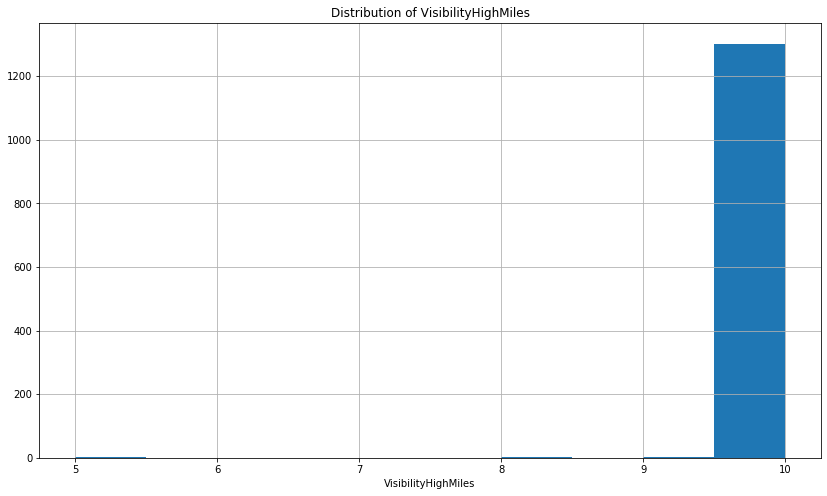

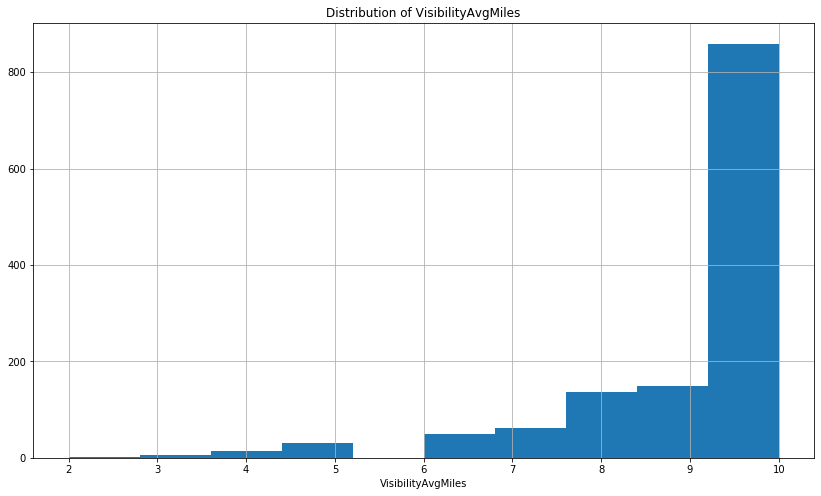

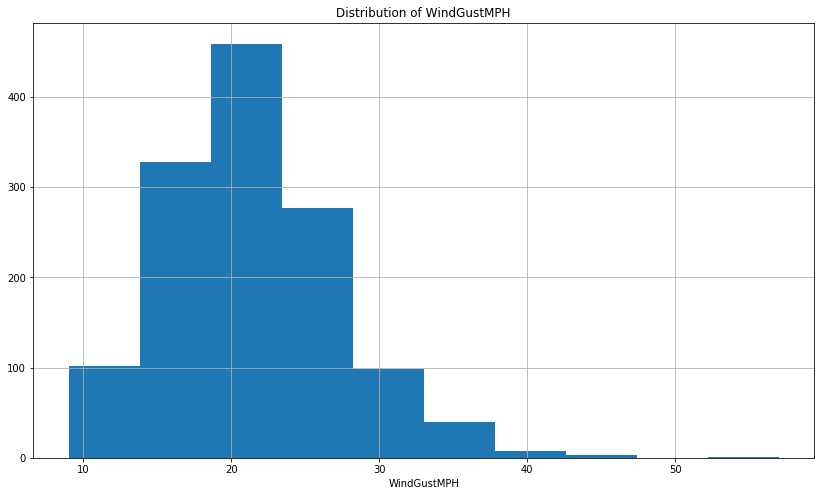

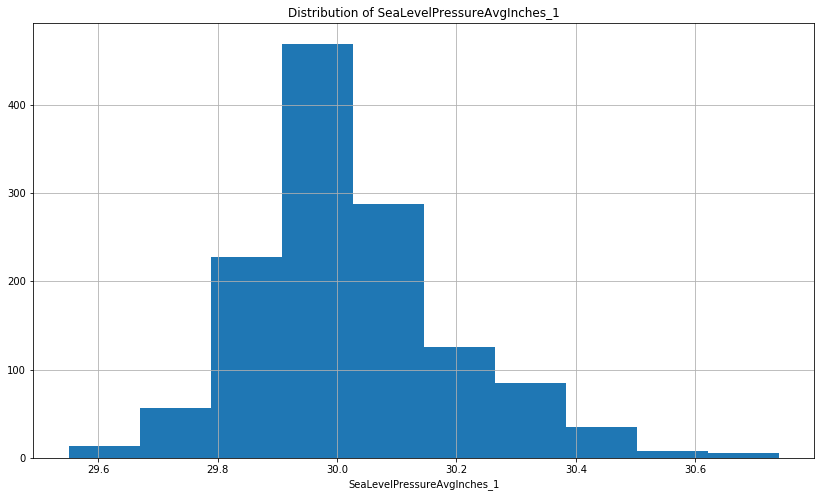

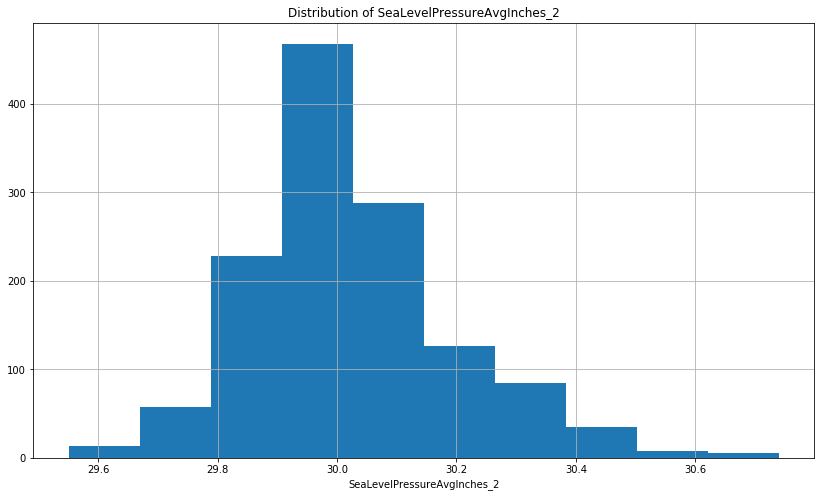

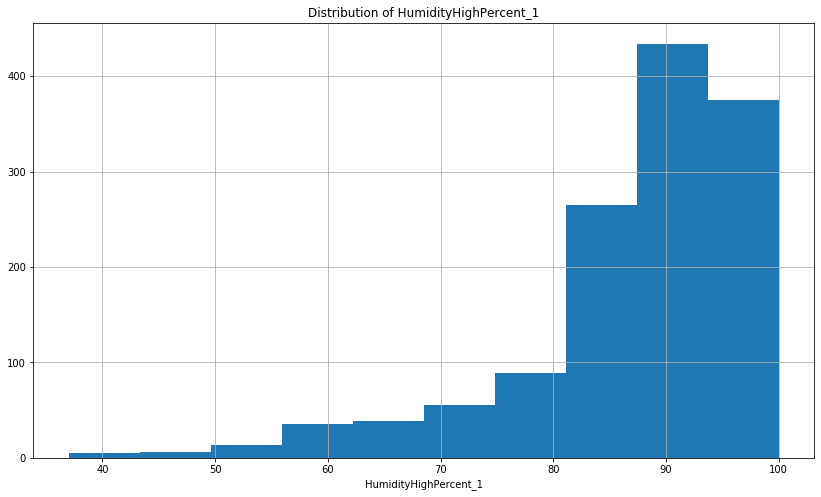

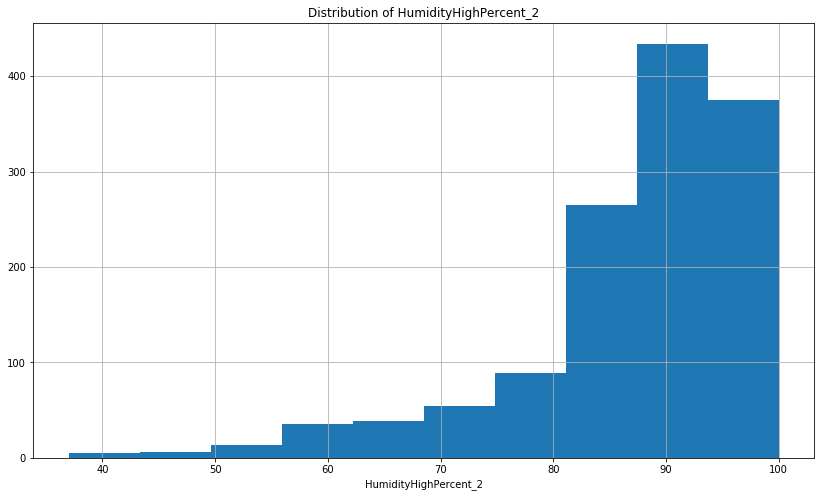

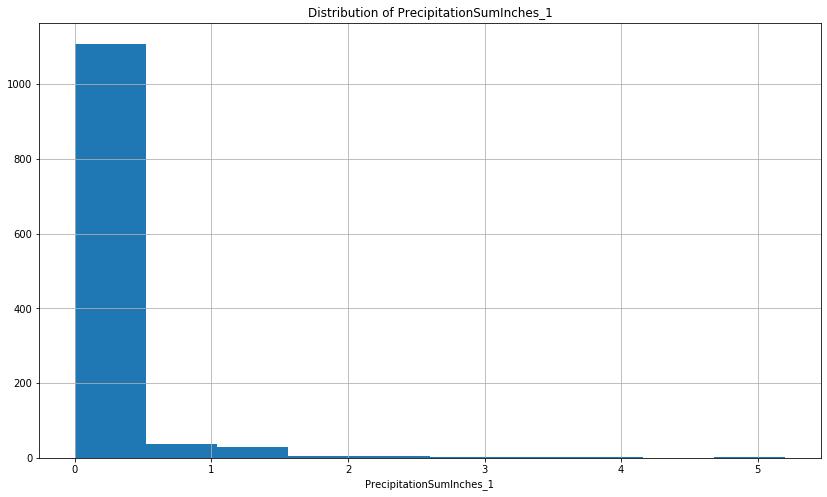

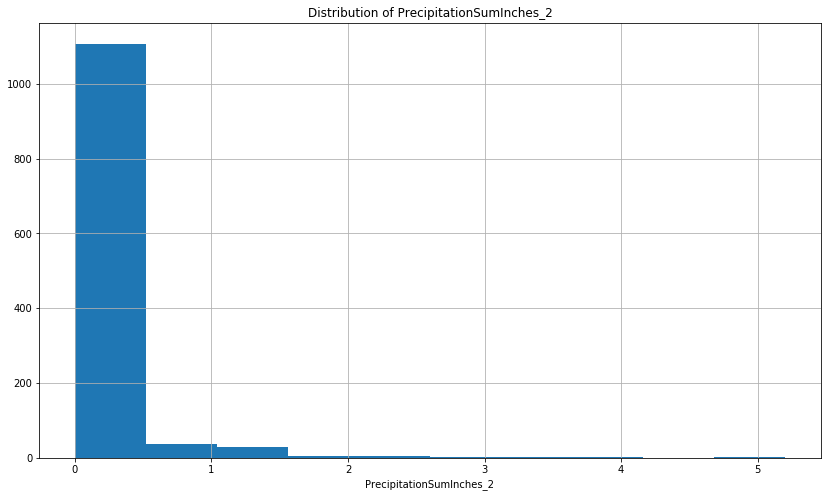

In [10]:
# Plotting a histogram for VisibilityHighMiles, WindGustMPH, VisibilityAvgMiles
# The histogram shows that there is not a lot of variance in the VisibilityHighMiles
# there is a potential for introducing spurious data artifacts
# # These will significantly impact or bias the models

outliers = ["VisibilityHighMiles", "VisibilityAvgMiles", "WindGustMPH", "SeaLevelPressureAvgInches_1",
           "SeaLevelPressureAvgInches_2", "HumidityHighPercent_1", "HumidityHighPercent_2", 
            "PrecipitationSumInches_1", "PrecipitationSumInches_2"]

for outlier in outliers:
    plt.rcParams['figure.figsize'] = [14, 8]
    df.hist(column=outlier)
    plt.title('Distribution of {}'.format(outlier))
    plt.xlabel(outlier)
    plt.show()

In [11]:
# Iterating over the precipitation columns and update null values to 0
for precip_col in ['PrecipitationSumInches_1', 'PrecipitationSumInches_2']:
    # create a boolean array of values representing nans
    missing_vals = pd.isnull(df[precip_col])
    df[precip_col][missing_vals] = 0

In [12]:
# Saving the Dataframe into a file for implementation of DNNRegressor later.
df.to_csv('for_DNNRegressor.csv')

In [13]:
#Dropping Events column because it is empty
df = df.drop(['Events'], axis=1)

#Dropping records with NaN values
df.dropna(inplace= True)

In [14]:
#Saving clean data file including the index of df to keep the dates
df.to_csv('clean_data.csv')

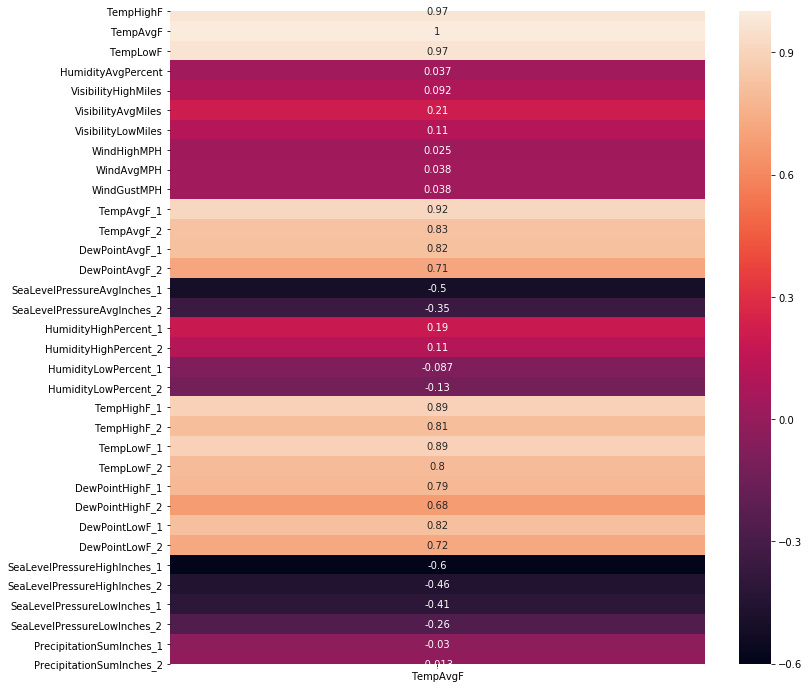

In [15]:
# Getting and storing correlation of Average temperature and create a heatmap
correlationMatrix = df.corr()[['TempAvgF']]
plt.figure(figsize=(12, 12))
sns.heatmap(correlationMatrix, annot=True,)

In [16]:
correlationMatrix.sort_values('TempAvgF')

,TempAvgF
SeaLevelPressureHighInches_1,-0.600386
SeaLevelPressureAvgInches_1,-0.502822
SeaLevelPressureHighInches_2,-0.456371
SeaLevelPressureLowInches_1,-0.408679
SeaLevelPressureAvgInches_2,-0.354517
SeaLevelPressureLowInches_2,-0.264731
HumidityLowPercent_2,-0.129954
HumidityLowPercent_1,-0.086692
PrecipitationSumInches_1,-0.029814
PrecipitationSumInches_2,-0.012898


In [17]:
# Predictors are the features with correlation > 0.6
predictors = ['TempAvgF_1',  'TempAvgF_2', 'TempLowF_1',   'TempLowF_2', 'DewPointAvgF_1', 'DewPointAvgF_2',
              'DewPointHighF_1',  'DewPointHighF_2', 'DewPointLowF_1',  'DewPointLowF_2',
              'TempHighF_1',   'TempHighF_2']

In [18]:
# Storing the average temperature feature and predictor features in a new DataFrame
df2 = df[['TempAvgF'] + predictors]

# Saving the new DataFrame into a file
df2.to_csv('selected_features.csv')
df2

,TempAvgF,TempAvgF_1,TempAvgF_2,TempLowF_1,TempLowF_2,DewPointAvgF_1,DewPointAvgF_2,DewPointHighF_1,DewPointHighF_2,DewPointLowF_1,DewPointLowF_2,TempHighF_1,TempHighF_2
Date,,,,,,,,,,,,,
2013-12-23,45,48.0,60.0,39.0,45.0,36.0,49.0,43.0,67.0,28.0,43.0,56.0,74.0
2013-12-24,46,45.0,48.0,32.0,39.0,27.0,36.0,31.0,43.0,23.0,28.0,58.0,56.0
2013-12-25,50,46.0,45.0,31.0,32.0,28.0,27.0,36.0,31.0,21.0,23.0,61.0,58.0
2013-12-26,48,50.0,46.0,41.0,31.0,40.0,28.0,44.0,36.0,36.0,21.0,58.0,61.0
2013-12-27,53,48.0,50.0,39.0,41.0,36.0,40.0,39.0,44.0,33.0,36.0,57.0,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-07-27,89,91.0,91.0,78.0,78.0,70.0,71.0,75.0,75.0,61.0,63.0,103.0,103.0
2017-07-28,91,89.0,91.0,75.0,78.0,67.0,70.0,71.0,75.0,61.0,61.0,103.0,103.0
2017-07-29,92,91.0,89.0,76.0,75.0,64.0,67.0,71.0,71.0,55.0,61.0,105.0,103.0


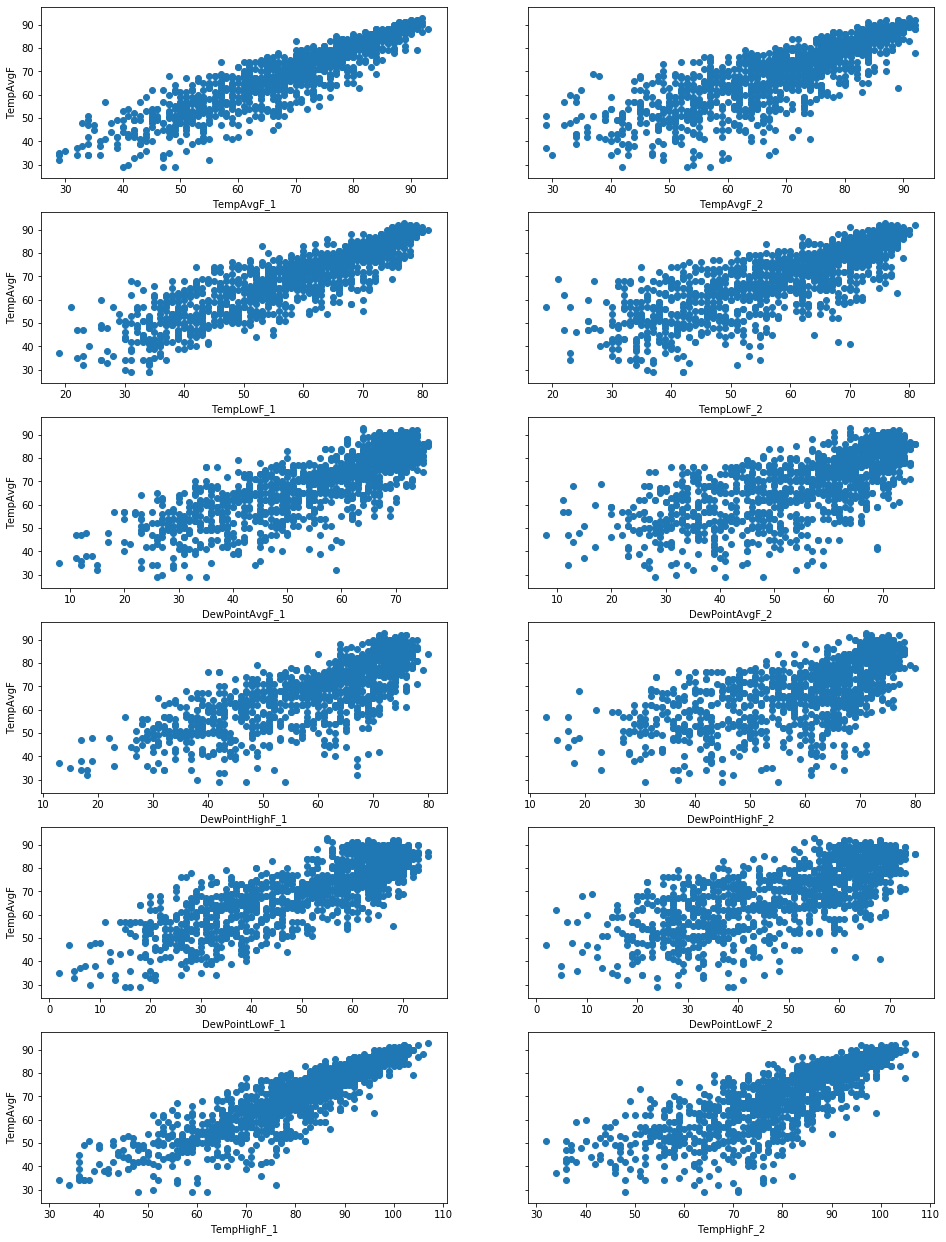

In [19]:
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that 
# the y axes should be shared
fig, axes = plt.subplots(nrows=6, ncols=2, sharey=True)

# Creating an array to rearrange the data into a 2D array of 6 rows and 2 columns
arr = np.array(predictors).reshape(6, 2)

# Using enumerate to loop over the created array
for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        # Creating scatter plots of Average temperature of each record vs each feature
        axes[row, col].scatter(df2[feature], df2['TempAvgF'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='TempAvgF')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

In [20]:
# Seperate predictor variables (X) from the outcome variable (Average Temperature) (y)
X = df2[predictors]
y = df2['TempAvgF']

# Add a constant to the predictor variable set to represent the Bo intercept
X = sm.add_constant(X)
X.ix[:5, :5]

,const,TempAvgF_1,TempAvgF_2,TempLowF_1,TempLowF_2
Date,,,,,
2013-12-23,1.0,48.0,60.0,39.0,45.0
2013-12-24,1.0,45.0,48.0,32.0,39.0
2013-12-25,1.0,46.0,45.0,31.0,32.0
2013-12-26,1.0,50.0,46.0,41.0,31.0
2013-12-27,1.0,48.0,50.0,39.0,41.0


In [21]:
# Selecting a significance value
alpha = 0.05

# Fit the model
model = sm.OLS(y, X).fit()

# Evaluating the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TempAvgF   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     696.0
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:58:07   Log-Likelihood:                -3961.7
No. Observations:                1299   AIC:                             7949.
Df Residuals:                    1286   BIC:                             8017.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               9.9788      1.054      9.464      0.000       7.910      12.047
TempAvgF_1         -1.1508      0.551     -2.089      0.037      -2.231      -0.070
TempAvgF_2         -1.3346      0.551     -2.422      0.016      -2.416      -0.253
TempLowF_1          0.9445      0.280      3.378      0.001       0.396       1.493
TempLowF_2          0.8690      0.278      3.123      0.002       0.323       1.415
DewPointAvgF_1     -0.3286      0.083     -3.959      0.000      -0.492      -0.166
DewPointAvgF_2     -0.0958      0.082     -1.173      0.241      -0.256       0.064
DewPointHighF_1     0.0320      0.054      0.594      0.553      -0.074       0.137
DewPointHighF_2    -0.0808      0.052     -1.565      0.118      -0.182       0.020
DewPointLowF_1      0.4310      0.045      9.559      0.000       0.343       0.519
DewPointLowF_2     -0.1140      0.047     -2.412      0.016      -0.207      -0.021
TempHighF_1         1.0355      0.277      3.741      0.000       0.492       1.579
TempHighF_2         0.6771      0.278      2.439      0.015       0.133       1.222
==============================================================================
Omnibus:                      121.758   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.708
Skew:                          -0.652   Prob(JB):                     2.14e-45
Kurtosis:                       4.450   Cond. No.                     1.72e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
# Identifying the predictor with the highest p-value and 
# checking if its value is higher than our selected alpha (in this case, 0.05)

# DewPointHighF_1 has the greatest calculated p-value above. It has a p-value of 0.553 (>0.05)
# Removing the DewPointHighF_1 feature from the DataFrame
X = X.drop('DewPointHighF_1', axis=1)

# Fit the model again 
model = sm.OLS(y, X).fit()

# Re-evaluating the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TempAvgF   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     759.7
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:58:07   Log-Likelihood:                -3961.9
No. Observations:                1299   AIC:                             7948.
Df Residuals:                    1287   BIC:                             8010.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.1334      1.022      9.920      0.000       8.129      12.137
TempAvgF_1         -1.1556      0.551     -2.099      0.036      -2.236      -0.075
TempAvgF_2         -1.3302      0.551     -2.415      0.016      -2.411      -0.249
TempLowF_1          0.9449      0.280      3.380      0.001       0.397       1.493
TempLowF_2          0.8670      0.278      3.117      0.002       0.321       1.413
DewPointAvgF_1     -0.2872      0.045     -6.375      0.000      -0.376      -0.199
DewPointAvgF_2     -0.0971      0.082     -1.191      0.234      -0.257       0.063
DewPointHighF_2    -0.0793      0.052     -1.538      0.124      -0.180       0.022
DewPointLowF_1      0.4154      0.037     11.335      0.000       0.344       0.487
DewPointLowF_2     -0.1107      0.047     -2.359      0.018      -0.203      -0.019
TempHighF_1         1.0396      0.277      3.758      0.000       0.497       1.582
TempHighF_2         0.6756      0.278      2.434      0.015       0.131       1.220
==============================================================================
Omnibus:                      120.732   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.284
Skew:                          -0.645   Prob(JB):                     2.65e-45
Kurtosis:                       4.459   Cond. No.                     1.60e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
# Identifying the predictor with the highest p-value and 
# checking if its value is higher than our selected alpha (in this case, 0.05)

# DewPointAvgF_2 has the greatest calculated p-value above. It has a p-value of 0.234 (>0.05)
# Removing the DewPointAvgF_2 feature from the DataFrame
X = X.drop('DewPointAvgF_2', axis=1)

# Fit the model again  
model = sm.OLS(y, X).fit()

# Re-evaluating the coefficients' p-values
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               TempAvgF   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     835.2
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:58:07   Log-Likelihood:                -3962.6
No. Observations:                1299   AIC:                             7947.
Df Residuals:                    1288   BIC:                             8004.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              10.3149      1.010     10.210      0.000       8.333      12.297
TempAvgF_1         -1.1920      0.550     -2.168      0.030      -2.271      -0.113
TempAvgF_2         -1.3249      0.551     -2.405      0.016      -2.406      -0.244
TempLowF_1          0.9666      0.279      3.465      0.001       0.419       1.514
TempLowF_2          0.8569      0.278      3.081      0.002       0.311       1.402
DewPointAvgF_1     -0.2923      0.045     -6.516      0.000      -0.380      -0.204
DewPointHighF_2    -0.1305      0.028     -4.593      0.000      -0.186      -0.075
DewPointLowF_1      0.4186      0.037     11.448      0.000       0.347       0.490
DewPointLowF_2     -0.1542      0.029     -5.239      0.000      -0.212      -0.096
TempHighF_1         1.0592      0.276      3.835      0.000       0.517       1.601
TempHighF_2         0.6722      0.278      2.422      0.016       0.128       1.217
==============================================================================
Omnibus:                      119.448   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              203.962
Skew:                          -0.638   Prob(JB):                     5.13e-45
Kurtosis:                       4.463   Cond. No.                     1.53e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
# Removing the const column
X = X.drop('const', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [25]:
# Instantiating the regressor class
regressor = LinearRegression()

# Fit the build the model by fitting the regressor to the training data
regressor.fit(X_train, y_train)

# Making a prediction set using the test set
prediction = regressor.predict(X_test)

# Evaluating the prediction accuracy of the model
print("The Explained Variance: %.2f" % regressor.score(X_test, y_test))
print("The Mean Absolute Error: %.2f degrees Farenheit" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f degrees Farenheit" % median_absolute_error(y_test, prediction))

The Explained Variance: 0.87
The Mean Absolute Error: 3.73 degrees Farenheit
The Median Absolute Error: 2.37 degrees Farenheit
